# Wind Prediction v.s. Climo

In this example we are compare the wind power feed-ins calculated based `ECMWF-opendata` with the historical average caculated from `ERA5`, both by `atlite`.

In [1]:
from collections import OrderedDict

import pandas as pd
import pgeocode
import xarray as xr

import atlite

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

sns.set_style("whitegrid")

### Download Necessary Data Files

1. We need to download the locations of all the PV installations in Germany to later
   tell atlite where to setup the PV panels and with which capacity.
   This information is available in Germany (thanks to the EEG feed-in-tariffs in
   the so-called "Anlagenregister").
2. We also download a reference time-series to compare our results against later.
   We retrieve the data from https://open-power-system-data.org which in return
   gets it from ENTSO-E.

In [14]:
cols = OrderedDict(
    (
        ("installation_date", "Inbetriebnahmedatum der Einheit"),
        ("plz", "Postleitzahl"),
        ("city", "Ort"),
        ("type", "Energieträger"),
        ("capacity", "Nettonennleistung der Einheit"),
        ("level", "Spannungsebene"),
        ("lat", "Koordinate: Breitengrad (WGS84)"),
        ("lon", "Koordinate: Längengrad (WGS84)"),
        ("validation", "Netzbetreiberprüfung"),
    )
)

filename = "Stromerzeuger_1_bis_25000 1_bis_25000 .csv"
database = pd.read_csv(
    filename,
    sep=";",
    decimal=",",
    usecols=list(cols.values()),
).rename(columns={v: k for k, v in cols.items()})
database

,type,capacity,installation_date,plz,city,lat,lon,validation,level
0,Wind,3000.0,9/1/2017,34298.0,Helsa,51.270068,9.739374,Geprüft,Hochspannung
1,Wind,3000.0,9/28/2017,23824.0,Damsdorf,54.073831,10.299400,Geprüft,Mittelspannung
2,Wind,3000.0,9/4/2017,34298.0,Helsa,51.272164,9.733069,Geprüft,Hochspannung
3,Wind,3000.0,8/31/2017,34298.0,Helsa,51.270462,9.748361,Geprüft,Hochspannung
4,Wind,2400.0,1/11/2017,52525.0,Heinsberg,51.029548,6.045546,Geprüft,Mittelspannung
...,...,...,...,...,...,...,...,...,...
24995,Wind,1800.0,4/22/2004,54597.0,Roth,50.321369,6.413358,Geprüft,Hochspannung
24996,Wind,2000.0,12/22/2005,39443.0,Staßfurt,51.898622,11.597868,Geprüft,Mittelspannung
24997,Wind,850.0,12/23/2002,36132.0,Eiterfeld,50.748250,9.772640,In Prüfung,Mittelspannung
24998,Wind,0.6,12/2/2010,6246.0,Bad Lauchstädt,NaN,NaN,Geprüft,Niederspannung (= Hausanschluss/Haushaltsstrom)


In [3]:
import os
import zipfile

import requests


def download_file(url, local_filename):
    # variant of http://stackoverflow.com/a/16696317
    if not os.path.exists(local_filename):
        r = requests.get(url, stream=True)
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
    return local_filename

### Germany wind installation

1.	打开 “扩展版单位总览（Erweiterte Einheitenübersicht）→ Stromerzeugungseinheiten（电力发电单元）”。页面支持筛选与 CSV 导出，且字段里有 Energieträger（能源/风）、Brutto-/Nettonennleistung（容量，kW）、Postleitzahl（PLZ）、Koordinate: Breitengrad/Längengrad (WGS84)（经纬度）等。 ￼
2.	在筛选栏设置（典型设置如下）：
	•	Energieträger = Wind（风能）
	•	Betriebs-Status = In Betrieb（在运），确保是存量在运装机

In [3]:
import pandas as pd
import pgeocode
from collections import OrderedDict

def load_capacities(
    typ,
    cap_range=None,
    until=None,
    filename="Stromerzeuger_1_bis_25000 1_bis_25000 .csv",
):
    """
    Read in and select capacities from MaStR CSV export.

    Parameters
    ----------
        typ : str
            Energy source, e.g. "Wind" or "Solar".
        cap_range : (optional) list-like
            [min, max) range of capacities (kW).
        until : str
            Limit to installations existing until this date (string format parsable by pandas).
        filename : str
            Path to MaStR CSV export file.
    """

    # Map columns from MaStR export
    cols = OrderedDict(
        (
            ("installation_date", "Inbetriebnahmedatum der Einheit"),
            ("plz", "Postleitzahl"),
            ("city", "Ort"),
            ("type", "Energieträger"),
            ("capacity", "Nettonennleistung der Einheit"),
            ("level", "Spannungsebene"),
            ("lat", "Koordinate: Breitengrad (WGS84)"),
            ("lon", "Koordinate: Längengrad (WGS84)"),
            ("validation", "Netzbetreiberprüfung"),
        )
    )

    database = pd.read_csv(
        filename,
        sep=";",
        decimal=",",
        usecols=list(cols.values()),
    ).rename(columns={v: k for k, v in cols.items()})

    # German postal codes must be strings
    database["plz"] = database["plz"].astype(str)

    # Parse dates
    database["installation_date"] = pd.to_datetime(
        database["installation_date"], errors="coerce", dayfirst=True
    )

    # Keep only valid + with PLZ
    database = database[
        (database["plz"].notna()) & (database["validation"] == "Geprüft")
    ]

    # Fill missing coordinates from postal codes
    de_nomi = pgeocode.Nominatim("de")
    plz_coords = de_nomi.query_postal_code(database["plz"].unique())
    plz_coords = plz_coords.set_index("postal_code")

    database.loc[database["lat"].isna(), "lat"] = database["plz"].map(
        plz_coords["latitude"]
    )
    database.loc[database["lon"].isna(), "lon"] = database["plz"].map(
        plz_coords["longitude"]
    )

    # Ignore entries still missing coordinates
    database = database[database["lat"].notna() & database["lon"].notna()]

    # Select by energy type
    data = database[database["type"] == typ].copy()

    # Select by date
    if until is not None:
        data = data[data["installation_date"] < pd.to_datetime(until)]

    # Select by capacity range
    if cap_range is not None:
        data = data[
            (cap_range[0] <= data["capacity"]) & (data["capacity"] < cap_range[1])
        ]

    # Convert to MW
    data["capacity"] = data.capacity / 1e3
    return data.rename(columns={"lon": "x", "lat": "y"})



The reference is downloaded from [Open Power System Data (OPSD)](https://data.open-power-system-data.org/time_series/) and contains data reported by the
TSOs and DSOs.

In [4]:
opsd_fn = download_file(
    "https://data.open-power-system-data.org/index.php?package=time_series&version=2019-06-05&action=customDownload&resource=3&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bfrom%5D=2012-01-01&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bto%5D=2013-05-01&filter%5BRegion%5D%5B%5D=DE&filter%5BVariable%5D%5B%5D=solar_generation_actual&filter%5BVariable%5D%5B%5D=wind_generation_actual&downloadCSV=Download+CSV",
    "time_series_60min_singleindex_filtered.csv",
)

In [5]:
opsd = pd.read_csv(opsd_fn, parse_dates=True, index_col=0)

# we later use the (in current version) timezone unaware datetime64
# to work together with this format, we have to remove the timezone
# timezone information. We are working with UTC everywhere.

opsd.index = opsd.index.tz_convert(None)

# We are only interested in the 2012 data
opsd = opsd[("2011" < opsd.index) & (opsd.index < "2013")]

### PV locations ("Anlagenregister")

Download and unzip the archive containing all reported PV installations in Germany in 2011 from [energymap.info](http://www.energymap.info).

In [6]:
eeg_fn = download_file(
    "http://www.energymap.info/download/eeg_anlagenregister_2015.08.utf8.csv.zip",
    "eeg_anlagenregister_2015.08.utf8.csv.zip",
)

with zipfile.ZipFile(eeg_fn, "r") as zip_ref:
    zip_ref.extract("eeg_anlagenregister_2015.08.utf8.csv")

## Prediction for Germany

In [4]:
init_time = pd.Timestamp.today().normalize()
cycle = 0
lead_time = pd.Timedelta(days=10)
valid_time = init_time + lead_time
print(f"Init time: {init_time}, lead time: {lead_time}, valid time: {valid_time.date()}")

Init time: 2025-09-29 00:00:00, lead time: 10 days 00:00:00, valid time: 2025-10-09


### Create a Cutout from IFS ENS

Load the country shape for Germany and determine its geographic bounds for downloading the appropriate cutout from ECMWF's ERA5 and Open data set.

In [5]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd

shp = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )
)
de_record = list(filter(lambda c: c.attributes["ISO_A2"] == "DE", shp.records()))[0]
de = pd.Series({**de_record.attributes, "geometry": de_record.geometry})
x1, y1, x2, y2 = de["geometry"].bounds

In [6]:
cutout = atlite.Cutout(
    path="germany-prediction.nc",
    module=["ifs_ens"],
    x=slice(x1 - 0.2, x2 + 0.2),
    y=slice(y1 - 0.2, y2 + 0.2),
    chunks={"time": 100},
    time=valid_time.strftime("%Y-%m-%d"),
    init_time=init_time.strftime("%Y-%m-%d"),
    cycle=cycle,
)

/workspaces/atlite-meets-earthkit-data/atlite/cutout.py:157: UserWarning: Arguments module, x, y, time, init_time, cycle are ignored, since cutout is already built.
  warn(


In [7]:
cutout.prepare()

<Cutout "germany-prediction">
 x = 5.75 ⟷ 15.00, dx = 0.25
 y = 47.25 ⟷ 55.25, dy = 0.25
 time = 2025-10-09 ⟷ 2025-10-09, dt = h
 module = ifs_ens
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

*Downloading the cutout can take a few seconds or even an hour, depending on your internet connection and whether the dataset
was recently requested from the data set provider (and is thus cached on their premise).
For us this took ~2 minutes the first time. Preparing it again (a second time) is snappy (for whatever reason you would want to download the same cutout twice).*

### Convert cutout into wind power

These wind turbines are available in atlite. 

In [8]:
for t in atlite.windturbines:
    print(f"* {t}")

* NREL_ReferenceTurbine_2020ATB_5.5MW
* Vestas_V47_660kW
* NREL_ReferenceTurbine_2019ORCost_15MW_offshore
* Vestas_V112_3MW_offshore
* NREL_ReferenceTurbine_2020ATB_4MW
* Suzlon_S82_1.5_MW
* Vestas_V164_7MW_offshore
* NREL_ReferenceTurbine_2016CACost_6MW_offshore
* NREL_ReferenceTurbine_2020ATB_18MW_offshore
* NREL_ReferenceTurbine_2016CACost_8MW_offshore
* NREL_ReferenceTurbine_2016CACost_10MW_offshore
* NREL_ReferenceTurbine_2020ATB_12MW_offshore
* Enercon_E126_7500kW
* Bonus_B1000_1000kW
* Vestas_V90_3MW
* NREL_ReferenceTurbine_2019ORCost_12MW_offshore
* NREL_ReferenceTurbine_5MW_offshore
* NREL_ReferenceTurbine_2020ATB_7MW
* Vestas_V80_2MW_gridstreamer
* Enercon_E101_3000kW
* Vestas_V25_200kW
* Vestas_V112_3MW
* Enercon_E82_3000kW
* Siemens_SWT_107_3600kW
* Siemens_SWT_2300kW
* NREL_ReferenceTurbine_2020ATB_15MW_offshore
* Vestas_V66_1750kW


We define capacity range to roughly match the wind turbine type. 

In [9]:
turbine_categories = [
    dict(name="Vestas_V25_200kW", up=400.0),
    dict(name="Vestas_V47_660kW", up=700.0),
    dict(name="Bonus_B1000_1000kW", up=1100.0),
    dict(name="Suzlon_S82_1.5_MW", up=1600.0),
    dict(name="Vestas_V66_1750kW", up=1900.0),
    dict(name="Vestas_V80_2MW_gridstreamer", up=2200.0),
    dict(name="Siemens_SWT_2300kW", up=2500.0),
    dict(name="Vestas_V90_3MW", up=50000.0),
]

In [10]:
low = 0
for index, turbine_cat in enumerate(turbine_categories):
    capacities = load_capacities(
        "Windkraft", cap_range=[low, turbine_cat["up"]], until="2026"
    )
    print(capacities)
    layout = cutout.layout_from_capacity_list(capacities, "capacity")

    turbine_categories[index]["layout"] = layout
    low = turbine_cat["up"]

Empty DataFrame
Columns: [type, capacity, installation_date, plz, city, y, x, validation, level]
Index: []
Empty DataFrame
Columns: [type, capacity, installation_date, plz, city, y, x, validation, level]
Index: []
Empty DataFrame
Columns: [type, capacity, installation_date, plz, city, y, x, validation, level]
Index: []
Empty DataFrame
Columns: [type, capacity, installation_date, plz, city, y, x, validation, level]
Index: []
Empty DataFrame
Columns: [type, capacity, installation_date, plz, city, y, x, validation, level]
Index: []
Empty DataFrame
Columns: [type, capacity, installation_date, plz, city, y, x, validation, level]
Index: []
Empty DataFrame
Columns: [type, capacity, installation_date, plz, city, y, x, validation, level]
Index: []
Empty DataFrame
Columns: [type, capacity, installation_date, plz, city, y, x, validation, level]
Index: []


We create a layout for each capacity range, each with a different windturbine model

In [20]:
wind = xr.Dataset()
for turbine_cat in turbine_categories:
    name = f"< {turbine_cat['up']} kW"
    wind[name] = cutout.wind(
        turbine=turbine_cat["name"],
        add_cutout_windspeed=True,
        interpolation_method="power",
        layout=turbine_cat["layout"],
        show_progress=False,
    )

wind["total"] = sum(wind[c] for c in wind)
wind

ValueError: could not interpret dimensions

Again, let's compare the result with the feed-in statistics from OPSD. We add an extra column for wind turbines with capacity lower than 1600 kW

In [23]:
compare = pd.DataFrame(
    {
        "atlite": wind["total"].squeeze().to_series(),
        "< 1600 kW": wind["< 1600.0 kW"].squeeze().to_series(),
        "opsd": opsd["DE_wind_generation_actual"],
    }
)

compare = compare / 1e3  # in GW

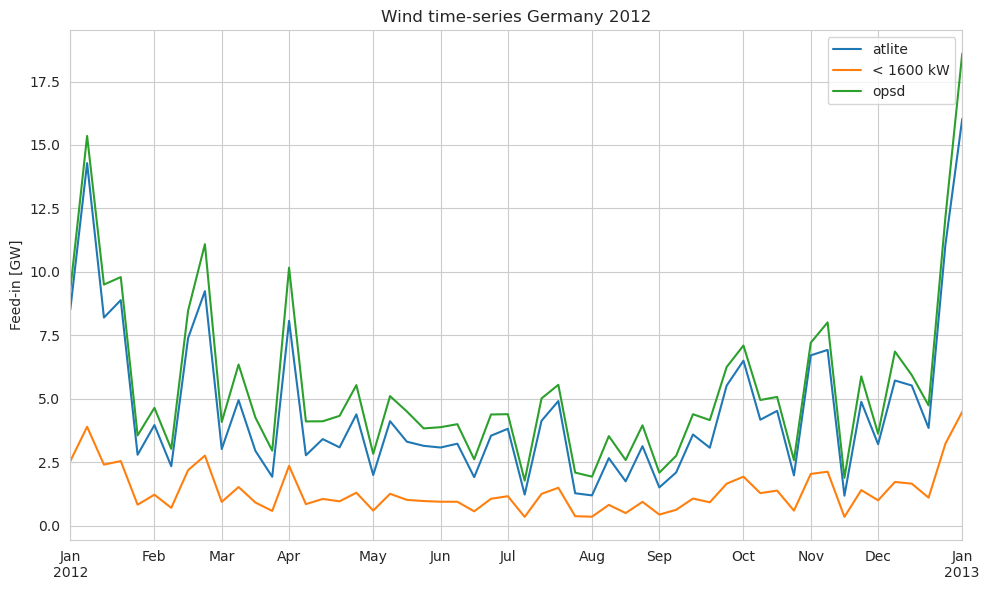

In [24]:
compare.resample("1W").mean().plot(figsize=(10, 6))
plt.ylabel("Feed-in [GW]")
plt.title("Wind time-series Germany 2012")
plt.tight_layout()

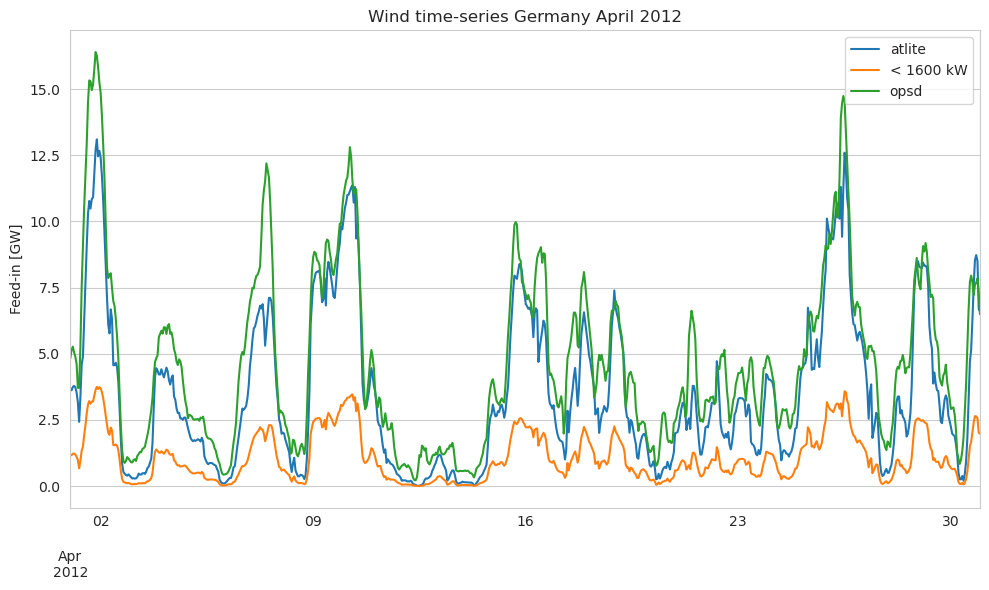

In [25]:
compare.loc["2012-04"].plot(figsize=(10, 6))
plt.ylabel("Feed-in [GW]")
plt.title("Wind time-series Germany April 2012")
plt.tight_layout()

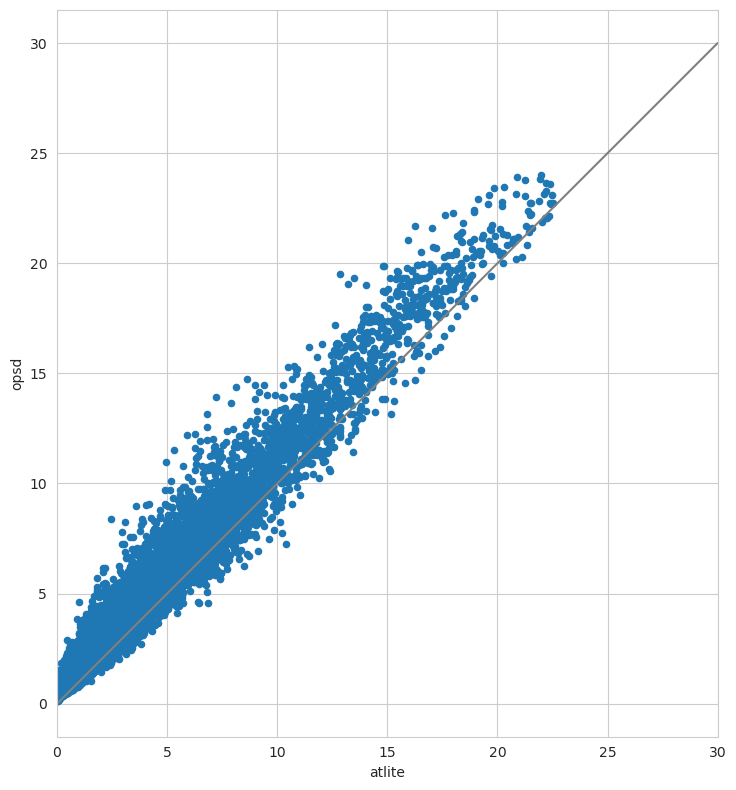

In [26]:
ax = compare.plot(x="atlite", y="opsd", kind="scatter", figsize=(12, 8))
ax.set_aspect("equal")
ax.set_xlim(0, 30)
ax.plot([0, 30], [0, 30], c="gray")
plt.tight_layout()

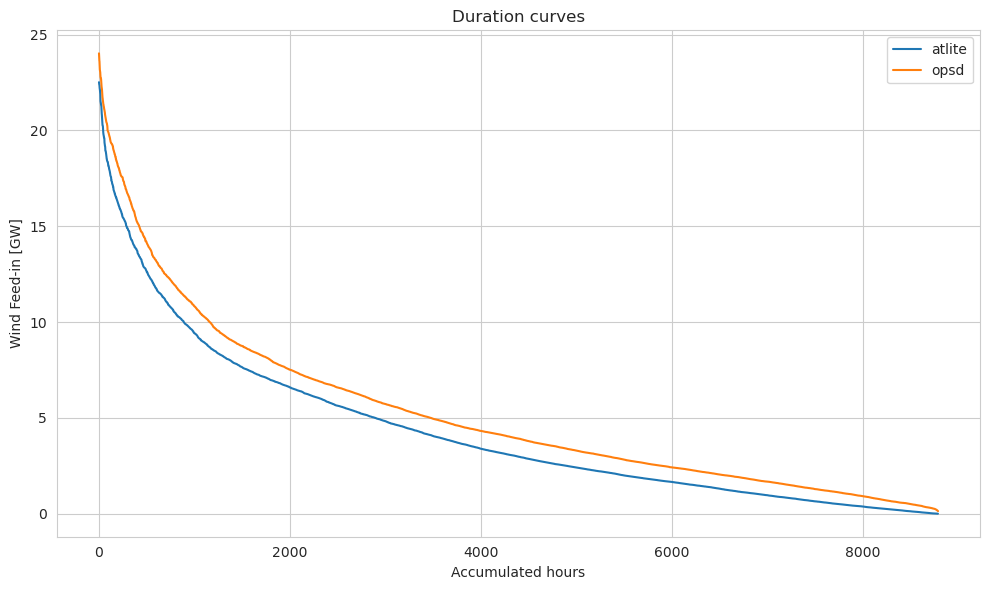

In [27]:
compare["atlite"].sort_values(ascending=False).reset_index(drop=True).plot(
    figsize=(10, 6)
)
compare["opsd"].sort_values(ascending=False).reset_index(drop=True).plot(
    figsize=(10, 6)
)
plt.legend()
plt.title("Duration curves")
plt.ylabel("Wind Feed-in [GW]")
plt.xlabel("Accumulated hours")
plt.tight_layout()

Looks quite aggreeable!

## Splitting time-series into shapes

The generation time-series can also be aggregated based on shapes.
In this example, we aggregate on the basis of the German "Länder" (federal states).

In [28]:
shp = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_1_states_provinces"
    )
)
de_records = list(
    filter(lambda r: r.attributes["iso_3166_2"].startswith("DE"), shp.records())
)
laender = (
    gpd.GeoDataFrame([{**r.attributes, "geometry": r.geometry} for r in de_records])
    .rename(columns={"iso_3166_2": "state"})
    .set_index("state")
    .set_crs(4236)
)

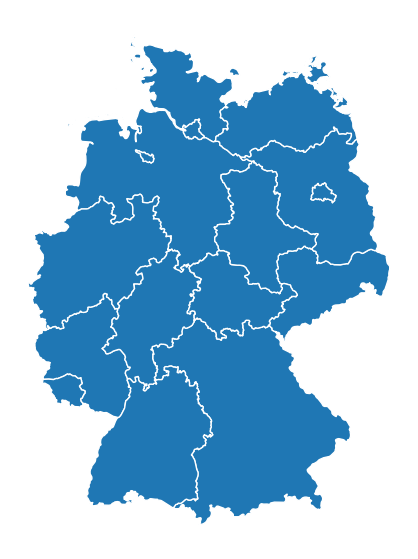

In [29]:
laender.to_crs(3035).plot(figsize=(7, 7))
plt.grid(False)
plt.axis("off");

In [30]:
pv = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 0.0},
    shapes=laender,
    layout=solar_layout,
)

/home/fabian/.miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


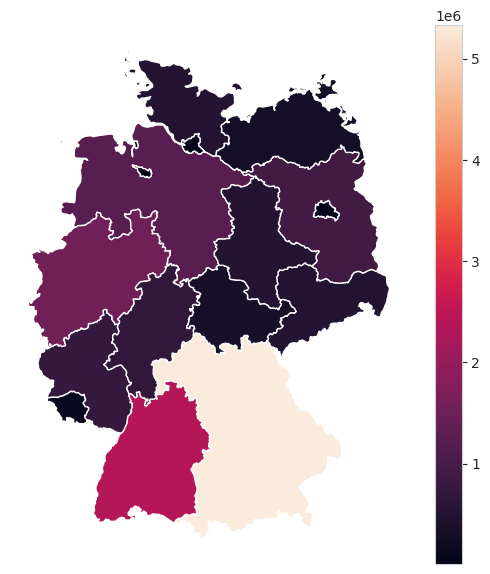

In [31]:
production = pv.sum("time").to_series()
laender.plot(column=production, figsize=(7, 7), legend=True)
plt.grid(False)
plt.axis("off");

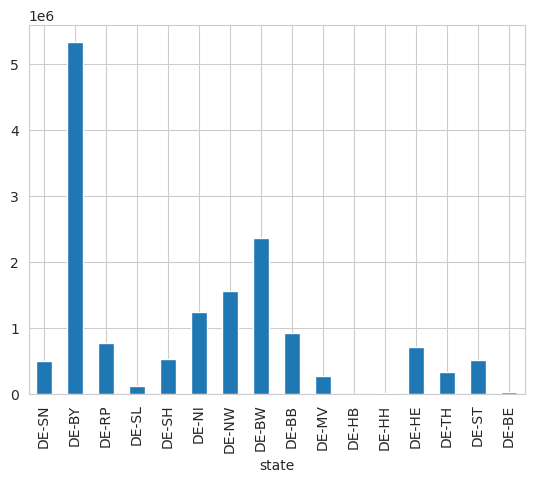

In [32]:
production.plot(kind="bar");